# Feature Importance and Explability in ML & QML

The first thing we need to do is load in all the modules and tools to build our classical models, generate our statistics, and create visualisations.

In [330]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms import QSVC,VQC

from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from tqdm import tqdm

# Standard imports
import numpy as np
import pandas as pd
import time
import warnings

from sklearn.utils import resample
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import shap
from alibi.explainers import ALE, plot_ale

In [49]:
shap.initjs()

## The Iris Dataset

The Iris data set is well-known and commonly used data set used for classification. It contains four features (petal length, petal width, sepal (the green leaf under the petal) lenght, and sepal width), and four classes - Setosa, Versicolor, and Virginica

Text(0.5, 1.02, 'Pairplot of Iris Dataset')

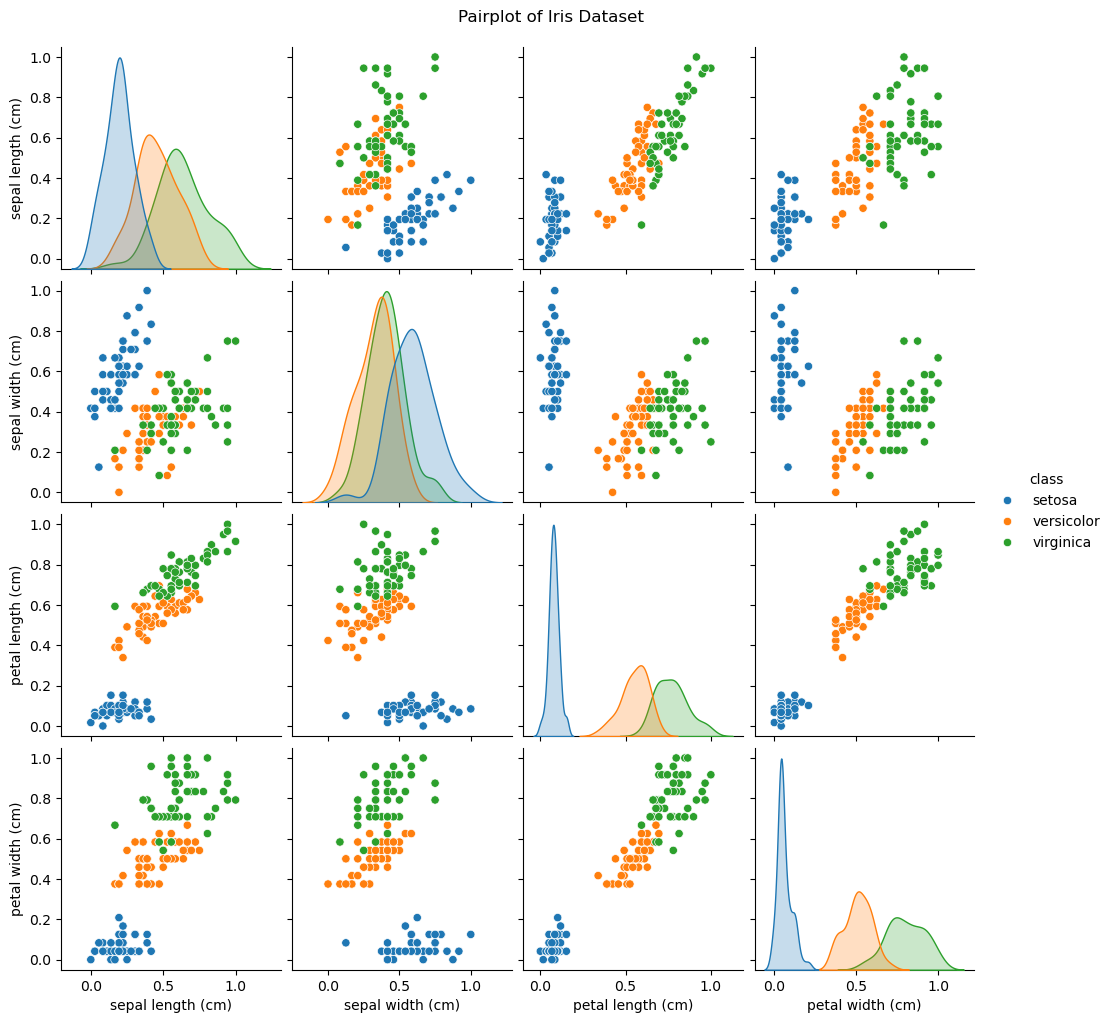

In [5]:
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target
features = MinMaxScaler().fit_transform(features)
df = pd.DataFrame(features, columns=iris_data.feature_names)
df['class'] = [iris_data.target_names[label] for label in iris_data.target]


plot = sns.pairplot(df, hue='class', palette='tab10')
plot.fig.suptitle("Pairplot of Iris Dataset", y=1.02)

We can see in the pairs plot above the setosa is easily seperated from the other two flowers, linearly seperable especially with respect to petal length.  

## Train and Load the models

We will be using a Support Vector Machine and Random Forest as out classical machine learning classifiers. Given the seperability of the data, these two methods perform extremely well with the Iris data. 

For our quantum models we will be using the Variational Quanum Classifier, and a Quantum Support Vector Classifier. To see how these are made please refer to [Iris VQC](iris_quantum_feature_importance.ipynb) and [Iris QSVC](iris_qsvm.ipynb) notebook.

For fitting and testing the models, we will be using an 80/20 split of the data. 

It is also worth noting that to properly compare with the quantum models, the data has been nomralised (this step allows the data to be mapped to the quantum state).

# **MOVE MODELING CELLS HERE**

In [53]:
qsvc_model = QSVC.load('quantum_classifiers/iris_qsvc.model')
vqc = VQC.load('quantum_classifiers/iris_vqc.model')

In [273]:
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

X = MinMaxScaler().fit_transform(X)

train_features, test_features, train_labels, test_labels = train_test_split(
        X, y, train_size=0.8, random_state=42)

svc_model = SVC(probability=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

svc_model.fit(train_features, train_labels)
rf_model.fit(train_features, train_labels)

RandomForestClassifier(random_state=42)

## Comparing the models

The most straightforward way to compare our models is to just check the accuracy of the models with the test. To best do this we use a technique called _bootstrapping_, this improves the trust of the accuracy score rather than doing simple check with the test subset, we can resample from this test multiple time, with replacement, to get a better understanding of how the model performs with the test data. 

# **MOVE BOOTSTRaP and Conf/ROC HERE**

In [ ]:
def bootstrap_score(model, X_test, y_test, n_iterations=1000, random_state=42):
    np.random.seed(random_state)  
    bootstrap_scores = []  
    ix = np.arange(len(X_test))  

    for i in tqdm(range(n_iterations), desc=f"Bootstrapping {model.__class__.__name__}"):
        boot = np.random.choice(ix, replace=True, size=len(X_test))  
        X_sample, y_sample = X_test[boot], y_test[boot]  
        score = model.score(X_sample, y_sample) 
        bootstrap_scores.append(score)  
    
    return bootstrap_scores

In [313]:
svc_scores = bootstrap_score(svc_model, test_features, test_labels, n_iterations = 1000, random_state = 42)
qsvc_scores = bootstrap_score(qsvc_model, test_features, test_labels, n_iterations = 1000, random_state = 42)
rf_scores = bootstrap_score(rf_model, test_features, test_labels, n_iterations = 1000, random_state = 42)
vqc_scores = bootstrap_score(vqc, test_features, test_labels, n_iterations = 1000, random_state = 42)

Bootstrapping VQC: 100%|██████████| 1000/1000 [02:07<00:00,  7.84it/s]


In [343]:
models = [svc_model, qsvc_model, rf_model, vqc]

In [ ]:
bootstrap_scores = svc_scores + qsvc_scores + rf_scores + vqc_scores 

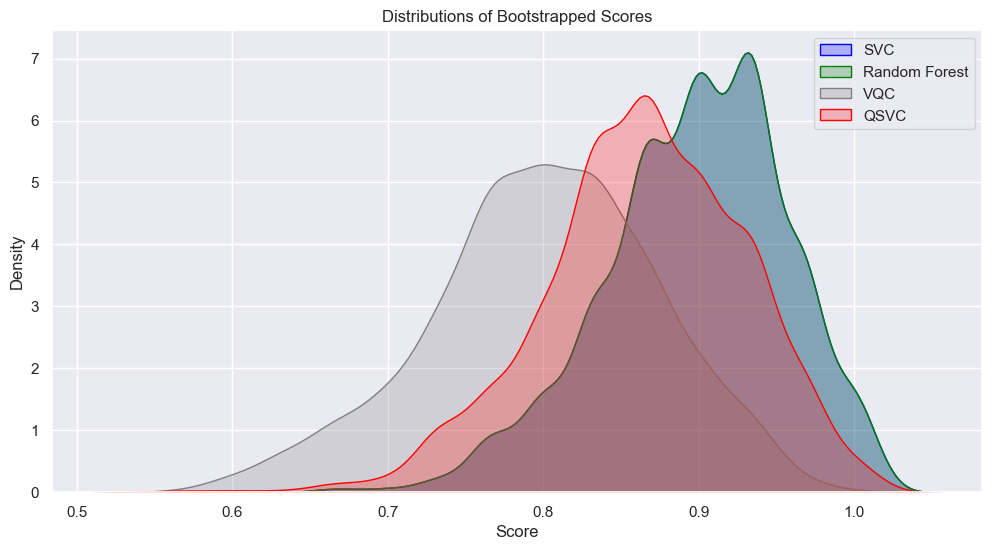

In [379]:
plt.figure(figsize=(12, 6))

sns.kdeplot(svc_bootstrap_scores, fill=True, label='SVC', color="blue", alpha=0.25)
sns.kdeplot(rf_bootstrap_scores, fill=True, label='Random Forest', color="green", alpha=0.25)
sns.kdeplot(vqc_scores, fill=True, label ='VQC', color='grey', alpha = 0.25)
sns.kdeplot(qsvc_scores, fill = True, label = 'QSVC', color='red', alpha = 0.25)

plt.title('Distributions of Bootstrapped Scores')
plt.xlabel('Score')
plt.ylabel('Density')
plt.savefig('Visuals/Model_accuracy_density_comparison.png')
plt.legend()
plt.show()


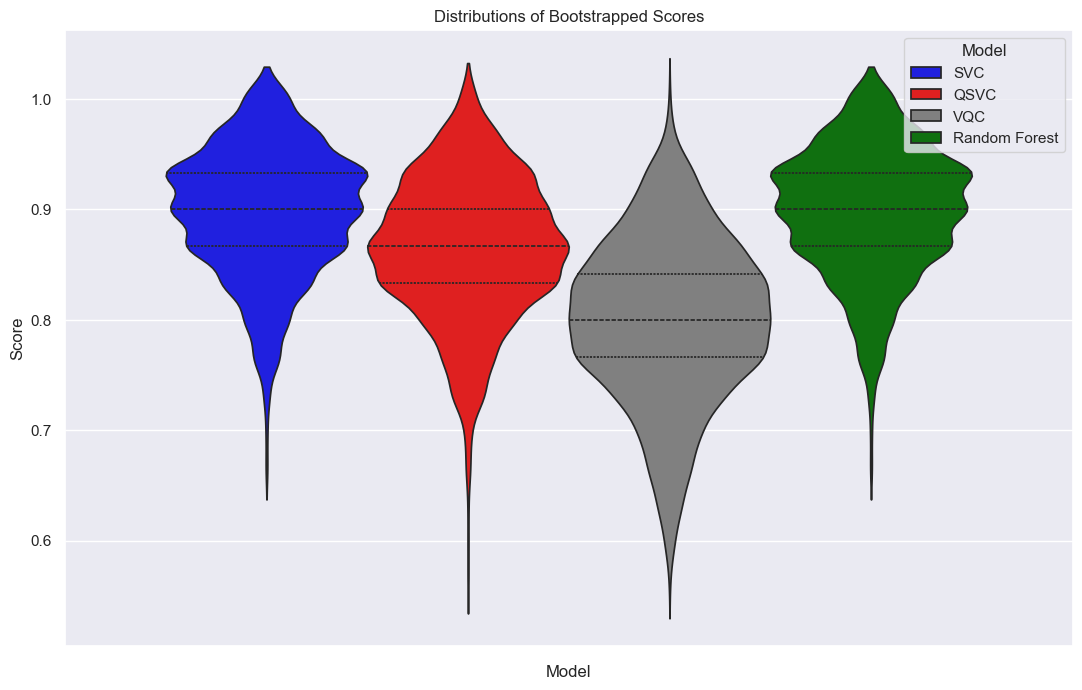

In [377]:
data = {
    'Score': svc_bootstrap_scores + qsvc_scores + vqc_scores + rf_bootstrap_scores,
    'Model': ['SVC'] * len(svc_bootstrap_scores) + ['QSVC'] * len(qsvc_scores) + ['VQC'] * len(vqc_scores) +
    ['Random Forest'] * len(rf_bootstrap_scores) 
              
}
df = pd.DataFrame(data)

plt.figure(figsize=(13, 8))

sns.violinplot(hue='Model', y='Score', data=df, palette=['blue', 'red', 'grey', 'green'],inner='quart')

plt.title('Distributions of Bootstrapped Scores')
plt.xlabel('Model')
plt.ylabel('Score')
plt.savefig('Visuals/Model_accuracy_violin_comparison.png')
plt.show()

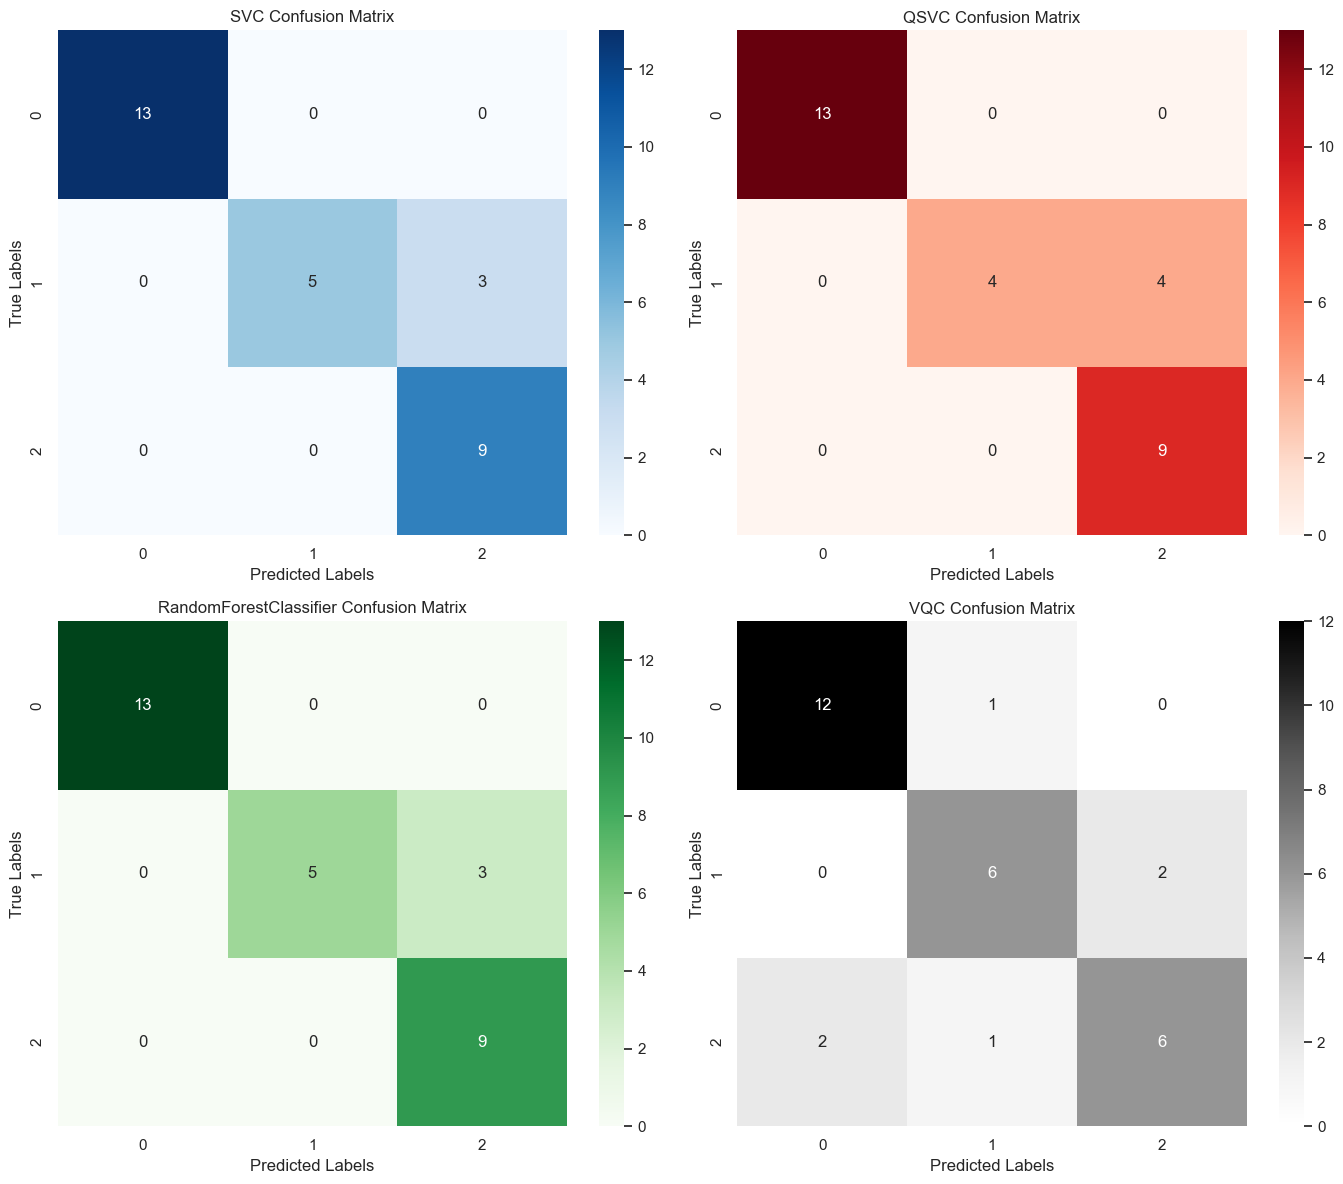

In [360]:
predictions = {}
confusion_matrices = {}


for model in models:
    model_name = type(model).__name__  
    predictions[model_name] = predict_labels(model, test_features)
    confusion_matrices[model_name] = confusion_matrix(test_labels, predictions[model_name])


fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten() 


cmaps = ["Blues", "Reds", "Greens", "Greys"]

for i, (model_name, cm) in enumerate(confusion_matrices.items()):
    cmap = cmaps[i % len(cmaps)]  
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap=cmap)
    axes[i].set_title(f'{model_name} Confusion Matrix')
    axes[i].set_xlabel('Predicted Labels')
    axes[i].set_ylabel('True Labels')

plt.tight_layout()
plt.savefig('Visuals/confusion_matrices.png')
plt.show()


# print('VQC Classification Report')
# print(classification_report(test_labels, predictions['VQC']))  

# print('SVC Classification Report')
# print(classification_report(test_labels, predictions['SVC']))  

# print('QSVC Classification Report')
# print(classification_report(test_labels, predictions['QSVC']))  

# print('RF Classification Report')
# print(classification_report(test_labels, predictions['RandomForestClassifier']))  


| Model | Metric | Class 0 | Class 1 | Class 2 | Accuracy | Macro Avg | Weighted Avg |
|-------|--------|---------|---------|---------|----------|-----------|--------------|
| VQC   | Precision | 0.86    | 0.75    | 0.75    | 0.80     | 0.79      | 0.80         |
|       | Recall    | 0.92    | 0.75    | 0.67    |          | 0.78      |              |
|       | F1-Score  | 0.89    | 0.75    | 0.71    |          | 0.78      |              |
| SVC   | Precision | 1.00    | 1.00    | 0.75    | 0.90     | 0.92      | 0.93         |
|       | Recall    | 1.00    | 0.62    | 1.00    |          | 0.88      |              |
|       | F1-Score  | 1.00    | 0.77    | 0.86    |          | 0.88      |              |
| QSVC  | Precision | 1.00    | 1.00    | 0.69    | 0.87     | 0.90      | 0.91         |
|       | Recall    | 1.00    | 0.50    | 1.00    |          | 0.83      |              |
|       | F1-Score  | 1.00    | 0.67    | 0.82    |          | 0.83      |              |
| RF    | Precision | 1.00    | 1.00    | 0.75    | 0.90     | 0.92      | 0.93         |
|       | Recall    | 1.00    | 0.62    | 1.00    |          | 0.88      |              |
|       | F1-Score  | 1.00    | 0.77    | 0.86    |          | 0.88      |              |


### Comparative Analysis and Implications


#### VQC (Variational Quantum Classifier)
- **Overall Performance**: Shows a balanced performance across classes with an overall accuracy of 80%.
- **Strengths**: Particularly strong in identifying class 0 (setosa), with high precision (0.86) and recall (0.92).
- **Weaknesses**: Slightly weaker in distinguishing class 2 (virginica), with a recall of 0.67, indicating that some virginica instances are missed. VQC is also the weakest classifier of the four. 

#### SVC (Support Vector Classifier)
- **Overall Performance**: The most accurate model with an overall accuracy of 90%.
- **Strengths**: Perfect precision and recall for class 0 (setosa). It also performs well for class 2 (virginica), with a perfect recall indicating all virginica instances are correctly identified.
- **Weaknesses**: Its recall for class 1 (versicolor) is lower at 0.62, suggesting that some versicolor instances are incorrectly classified.

#### QSVC (Quantum Support Vector Classifier)
- **Overall Performance**: An accuracy of 87%, slightly less than the classical SVC.
- **Strengths**: Perfect precision for classes 0 (setosa) and 1 (versicolor), with a high recall for class 2 (virginica).
- **Weaknesses**: The recall for class 1 (versicolor) is only 0.50, meaning half of the versicolor instances are misclassified.

#### RF (Random Forest)
- **Overall Performance**: Matches the classical SVC in accuracy at 90%.
- **Strengths**: Shows excellent performance for class 0 (setosa) with perfect precision and recall. It also performs very well for class 2 (virginica) with a recall of 1.00.
- **Weaknesses**: Similar to the SVC, its weakness lies in classifying class 1 (versicolor) with a recall of 0.62, indicating some versicolor instances are misclassified.

#### Comparative Analysis
- **Highest Accuracy**: Shared by SVC and RF at 90%, indicating strong overall performance.
- **Quantum vs. Classical**: The QSVC shows competitive performance with classical models, indicating the potential of quantum models in machine learning tasks. However, it slightly underperforms compared to its classical counterpart (SVC) in terms of overall accuracy.
- **Weakness Across Models**: Class 1 (versicolor) appears to be the most challenging class to classify correctly for all models, as indicated by lower recall values.
- **Class 0 Performance**: All models perform exceptionally well in identifying class 0 (setosa), with perfect scores in many cases.

The results suggests that while quantum models (especially the  QSVC) show promising results, classical models (SVC and RF) still hold a slight edge in overall accuracy, particularly in the handling of class 1 (versicolor). It is also importance to note that these are results from just the test set of a small dataset.

## Feature Importance

Feature importance is an important tool in understanding a machine learning model. It is great way to get a generalization of why the model is acting the way it is, and what features are being assigned the most weight in making a decision. 

### LOO (Leave One Out)

This is a very rough and very inefficient way to check feature importance: but probably the most intuative and understandable.

The general idea is **if we remove a feature, how much does this effect the model**, if we notice that accuracy decreases when a feature is removed, it is safe to say that that feature has a high level of importance. 

In [395]:
iris_data = load_iris()
full_features = iris_data.data
labels = iris_data.target  

data_descriptions = ["Full Features", "Missing Sepal Length", "Missing Sepal Width", "Missing Petal Length",
                     "Missing Petal Width"]

In [396]:
progress = {}
iris_LOO_scores = {}

for i, description in enumerate(data_descriptions):
    if i == 0:
        adjusted_features = full_features.copy()
    else:
        adjusted_features = np.delete(full_features, i-1, axis=1)

    num_features = adjusted_features.shape[1]

    adjusted_features = MinMaxScaler().fit_transform(adjusted_features)
    train_features, test_features, train_labels, test_labels = train_test_split(
        adjusted_features, labels, train_size=0.8, random_state=4701)

    iterations = range(1, 101)  
    train_scores = []
    test_scores = []

    warnings.filterwarnings('ignore')

    for i in iterations:
        svc = SVC()
        svc.fit(train_features, train_labels)  

        test_score_classical = svc.score(test_features, test_labels)

        test_scores.append(test_score_classical)

    progress[description] = test_scores

    iris_LOO_scores[description] = {
        "Test": test_score_classical
    }


In [400]:
progress = {}
rf_iris_LOO_scores = {}

for i, description in enumerate(data_descriptions):
    if i == 0:
        adjusted_features = full_features.copy()
    else:
        adjusted_features = np.delete(full_features, i-1, axis=1)

    num_features = adjusted_features.shape[1]

    adjusted_features = MinMaxScaler().fit_transform(adjusted_features)
    train_features, test_features, train_labels, test_labels = train_test_split(
        adjusted_features, labels, train_size=0.8, random_state=4701)

    iterations = range(1, 101)  
    train_scores = []
    test_scores = []

    warnings.filterwarnings('ignore')

    for i in iterations:
        rf = RandomForestClassifier()
        rf.fit(train_features, train_labels)  

        test_score_classical = rf.score(test_features, test_labels)

        test_scores.append(test_score_classical)

    progress[description] = test_scores

    rf_iris_LOO_scores[description] = {
        "Test": test_score_classical
    }


In [412]:
def LOO_plots(scores,model):
    full_feature_score = scores['Full Features']['Test']
    for feature_set, score_info in scores.items():
        if feature_set != 'Full Features':
            absolute_difference = abs(score_info['Test'] - full_feature_score)
            percentage_difference = (absolute_difference / full_feature_score) * 100
            scores[feature_set]['Absolute Difference'] = absolute_difference
            scores[feature_set]['Percentage Difference'] = percentage_difference

    categories = list(scores.keys())
    test_scores = [score_info['Test'] for score_info in scores.values()]
    abs_diff_scores = [score_info.get('Absolute Difference', 0) for score_info in scores.values()]
    perc_diff_scores = [score_info.get('Percentage Difference', 0) for score_info in scores.values()]

    model_name = type(model).__name__
    
    # Test Scores 
    plt.figure(figsize=(10, 6))
    plt.barh(categories, test_scores, color='green')
    plt.axvline(x=full_feature_score, color='red', linestyle='--', label='Full Features Score')
    plt.xlabel('Test Scores')
    plt.title(f'{model_name} Test Scores')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'Visuals/{model_name}_LOO_test_scores.png')
    plt.show()


    plt.figure(figsize=(10, 6))
    plt.barh(categories, perc_diff_scores, color='orange')
    plt.xlabel('Percentage Difference (%)')
    plt.title(f'{model_name} Percentage Difference from Full')
    plt.tight_layout()
    plt.savefig(f'Visuals/{model_name}_LOO_test_percentscores.png')
    plt.show()
    plt.close()


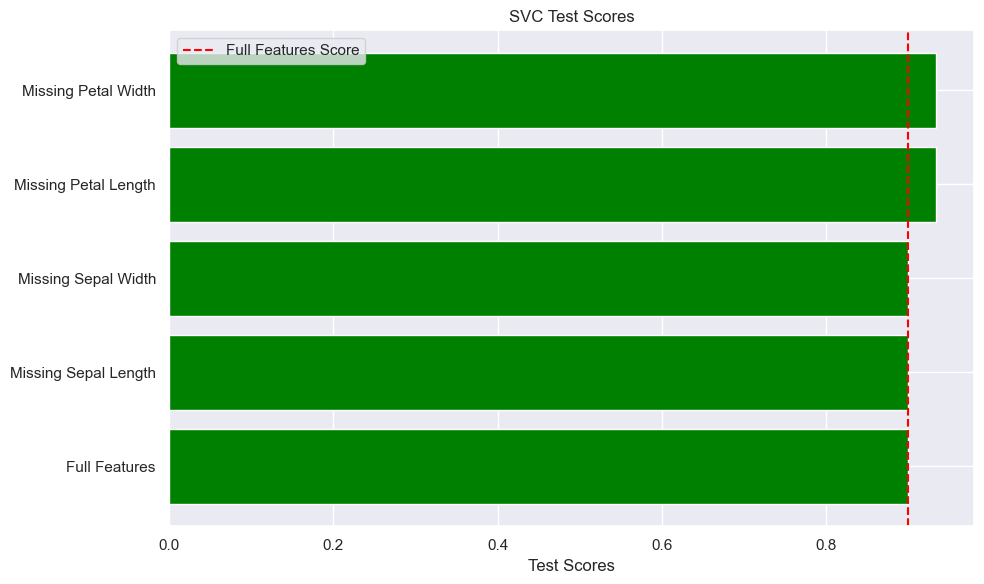

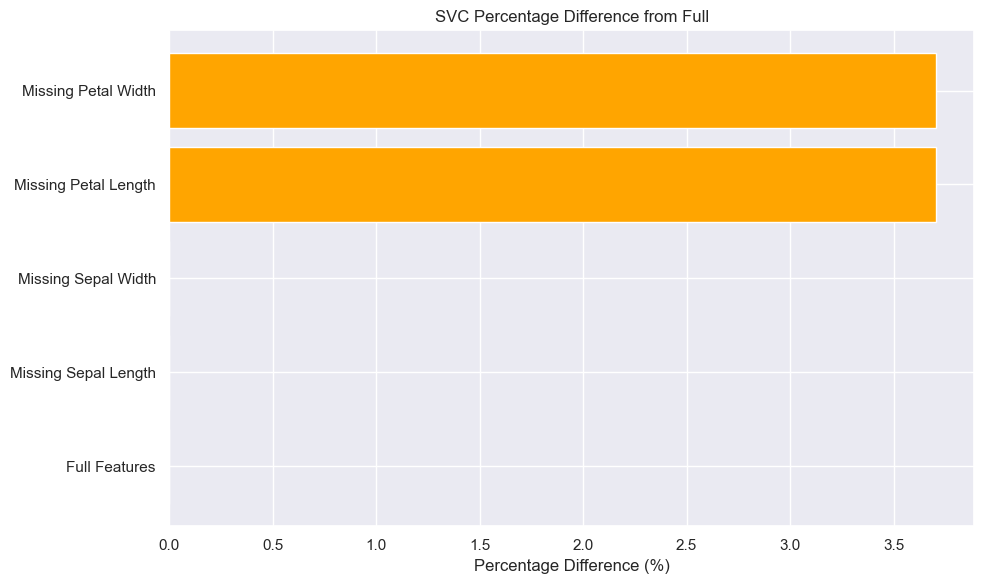

In [413]:
LOO_plots(iris_LOO_scores,svc_model)

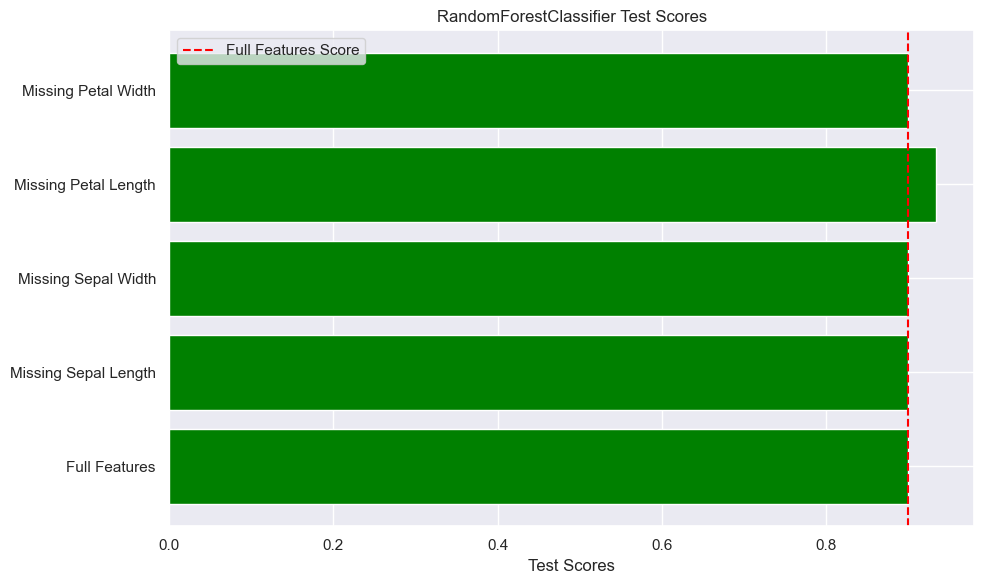

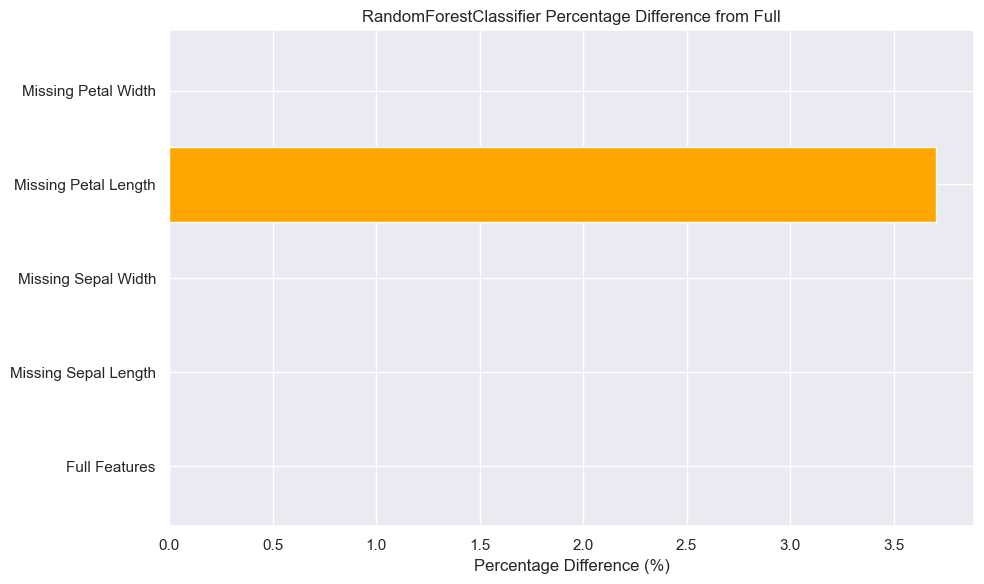

In [415]:
LOO_plots(rf_iris_LOO_scores,rf_model)

# Permutation Importance

How permutation importance works is we will take the column of the feature of interest, and shuffle it. This step should break any correlation between the feature and the class that would be predicted. By repeatedly shuffling the column we can get an aggregation of how much the model accuracy is changed, and assign a permutation importance score to the model. 

In [382]:
permutation_rankings = pd.DataFrame(columns = ['model','Feature','Rank'])
feature_perm_importances = pd.DataFrame(columns = [])

# SVC

In [392]:
def plot_permutation_importance(model):
    feature_names_array = np.array(iris.feature_names)
    r = permutation_importance(model, test_features, test_labels, n_repeats=30, random_state=42)

    sorted_importances_idx = r.importances_mean.argsort()[::-1]
    
    importances = pd.DataFrame(r.importances[sorted_importances_idx].T,
                               columns=feature_names_array[sorted_importances_idx])
    

    
    sorted_scores = r.importances_mean[sorted_importances_idx]
    sorted_features = feature_names_array[sorted_importances_idx]

    model_name = model.__class__.__name__
    importances['model'] = model_name
    
    ranked_features = pd.DataFrame({
        'Model': model_name,
    
        'Feature': sorted_features,
        'Score': sorted_scores, 
        'Method': 'Permutation'  
    })
    global permutation_rankings
    global feature_perm_importances
    permutation_rankings = pd.concat([permutation_rankings, ranked_features], ignore_index=True)
    feature_perm_importances = pd.concat([feature_perm_importances, importances])
    
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"{model_name} Permutation Importances")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    plt.tight_layout()
    plt.show()

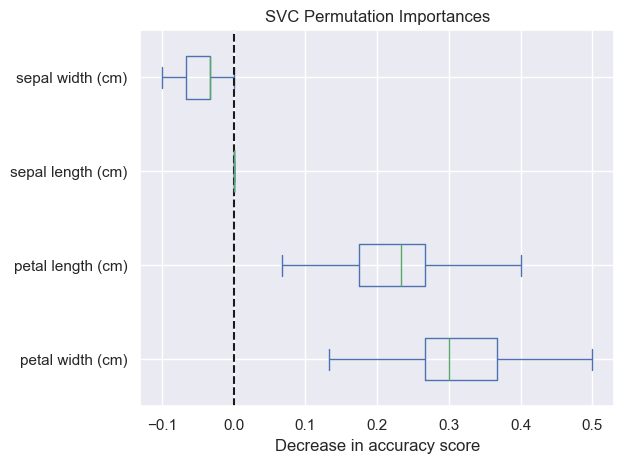

In [393]:
plot_permutation_importance(svc_model)

## Random Forest

<Figure size 1200x600 with 0 Axes>

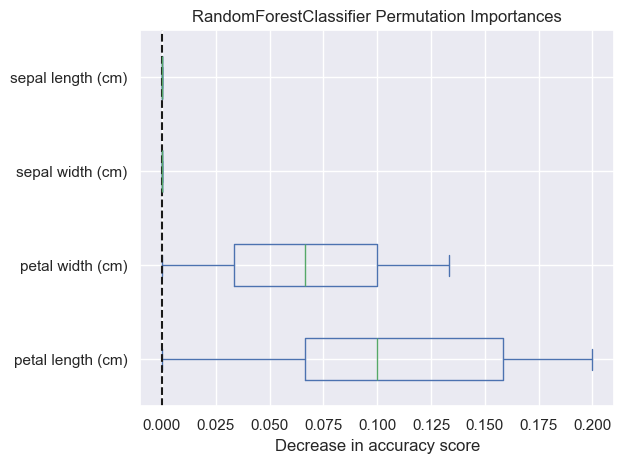

In [391]:
plot_permutation_importance(rf_model)

## VQC

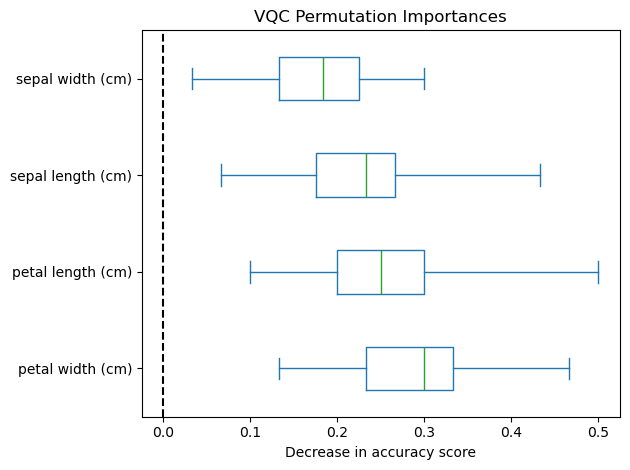

In [230]:
plot_permutation_importance(vqc)

# QSVC

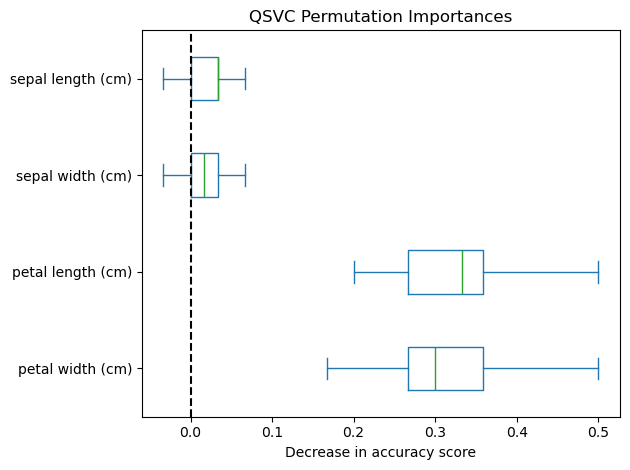

In [231]:
plot_permutation_importance(qsvc_model)

In [257]:
df = feature_perm_importances

In [381]:
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='Feature', y='Score', hue='Model')

plt.title('Feature Importance Scores Across Models', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Importance Score', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

ValueError: Could not interpret value `Feature` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x800 with 0 Axes>

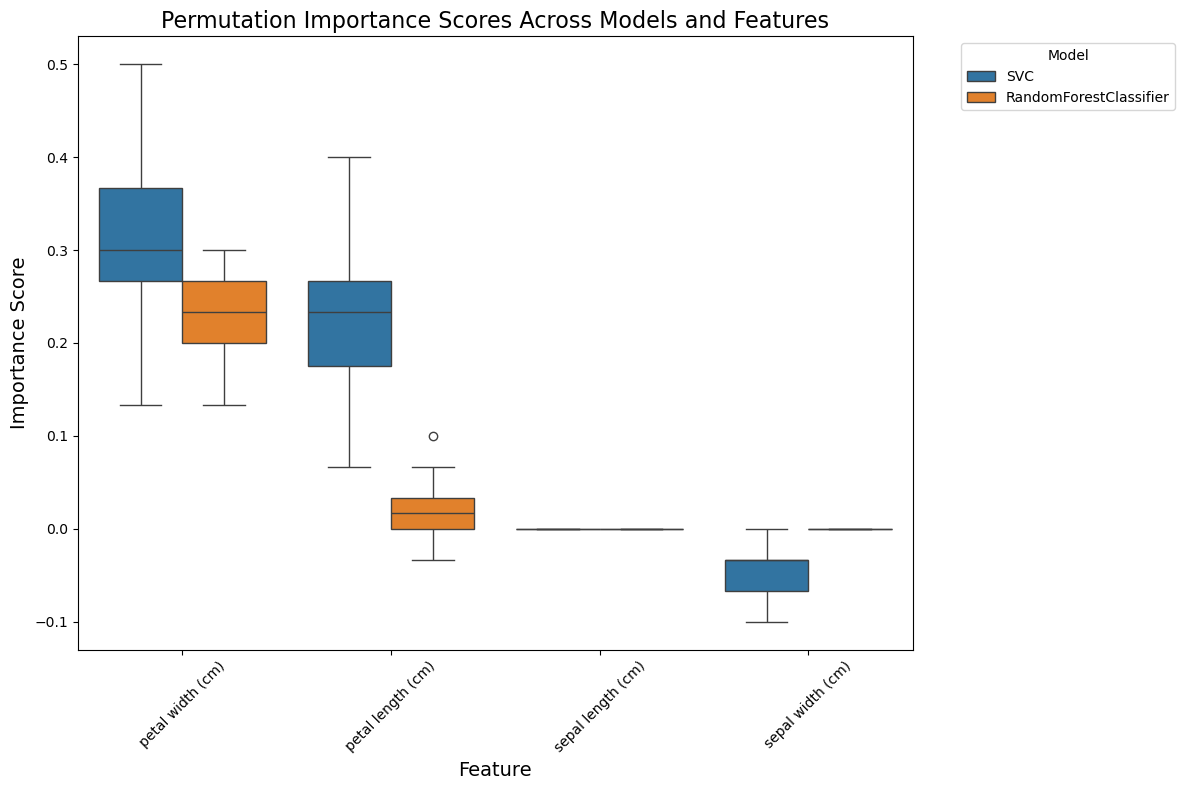

In [258]:
df_long = pd.melt(df, id_vars=['model'], var_name='Feature', value_name='Score')

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_long, x='Feature', y='Score', hue='model')

plt.title('Permutation Importance Scores Across Models and Features', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Importance Score', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## ALE

Accumulated Local Effects, or ALE, was designed as in improvement to Paritial Dependency Plots, by being more robust against strongly correlated features. ALE works by breaking a two dimenional plot of the feature of interest against the prediction into multiple frames. ALE will then get a measure of how much the predicstion changes across each segment in the feature values, and then as the name suggests, aggregates he results to get a final ALE score. Due to the nature of ALE, for making categorical prediction, the responding value would be the _probability_ of the model predicting a class, given a feature value. These values can also be aggregated accross all the classes to get an importance score for each of the features in the model.

Due to the implementation of VQC, we cannot access the probability of the classes and so are unable to implement ALE on the VQC model. 

In [ ]:
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names


train_features, test_features, train_labels, test_labels = train_test_split(
        X, y, train_size=0.8, random_state=4701)

In [ ]:
svc_model = SVC(probability=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=4701)

svc_model.fit(train_features, train_labels)
rf_model.fit(train_features, train_labels)

def predict_fn_svc(x):
    return svc_model.predict_proba(x)

def predict_fn_rf(x):
    return rf_model.predict_proba(x)

ale_svc = ALE(predict_fn_svc, feature_names=feature_names, target_names=target_names)
ale_rf = ALE(predict_fn_rf, feature_names=feature_names, target_names=target_names)


exp_svc = ale_svc.explain(test_features)
exp_rf = ale_rf.explain(test_features)

#  SVC model
plot_ale(exp_svc, n_cols=2, fig_kw={'figwidth': 8, 'figheight': 5});

In [ ]:
plot_ale(exp_rf, n_cols=2, fig_kw={'figwidth': 8, 'figheight': 5});

In [ ]:
from qiskit_machine_learning.algorithms import QSVC
qsvc_model = QSVC.load('quantum_classifiers/iris_qsvc.model')

In [ ]:
def predict_fn_qsvc(x):
    return qsvc_model.predict_proba(x)

ale_qsvc = ALE(predict_fn_qsvc, feature_names=feature_names, target_names=target_names)
exp_qsvc = ale_qsvc.explain(test_features)

plot_ale(exp_qsvc, n_cols=2, fig_kw={'figwidth': 8, 'figheight': 5});

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 5), sharey='row');
plot_ale(exp_rf, features=[0,1,2,3], targets=['setosa'], ax=ax, line_kw={'label': 'RF'});
plot_ale(exp_svc, features=[0,1,2,3], targets=['setosa'], ax=ax, line_kw={'label': 'SVC'});
plot_ale(exp_qsvc, features=[0,1,2,3], targets=['setosa'], ax=ax, line_kw={'label': 'QSVC'});

# SHAP

SHapley Additive exPlanations utilise game theory to explain the ouput of a model. 

In [ ]:
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

train_X, test_X, train_y, test_y = train_test_split(
    features, labels, train_size=0.8, random_state=4701)

svc_model = SVC(probability=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

svc_model.fit(train_X, train_y)
rf_model.fit(train_X,train_y)

svc_explainer = shap.KernelExplainer(svc_model.predict, test_X)
rf_explainer = shap.KernelExplainer(rf_model.predict, test_X)
qsvc_explainer = shap.KernelExplainer(qsvc_model.predict, test_X)

svc_shap_values = svc_explainer(test_X)
rf_shap_values = rf_explainer(test_X)
qsvc_shap_values = qsvc_explainer(test_X)

## SVC

In [ ]:
shap.summary_plot(svc_shap_values, test_X, feature_names=feature_names, title='SHAP Values for SVC Model')
plt.savefig('Visuals/iris_svc_shap.png')
plt.close()

In [ ]:
# svc_shap_values = svc_explainer.shap_values(test_X)
shap.force_plot(svc_explainer.expected_value, svc_shap_values[0,], test_X[0], feature_names=feature_names)

In [ ]:
shap.summary_plot(svc_shap_values,feature_names = feature_names, plot_type = 'bar')

In [ ]:
shap.plots._waterfall.waterfall_legacy(svc_explainer.expected_value, svc_shap_values[2])

## Random Forest

In [ ]:
shap.summary_plot(rf_shap_values, test_X, feature_names=feature_names, title='SHAP Values for RandomForestClassifier Model')
plt.savefig('Visuals/iris_rf_shap.png')
plt.close()

In [ ]:
# rf_shap_values = rf_explainer.shap_values(test_X)

shap.force_plot(rf_explainer.expected_value, rf_shap_values[0,], test_X[0], feature_names=feature_names)

In [ ]:
shap.summary_plot(rf_shap_values,feature_names = feature_names, plot_type = 'bar')

In [ ]:
shap.plots._waterfall.waterfall_legacy(rf_explainer.expected_value, rf_shap_values[2])

## QSVC

In [ ]:
shap.summary_plot(qsvc_shap_values, test_X, feature_names=feature_names, title='SHAP Values for SVC Model')
plt.savefig('Visuals/iris_qsvc_shap.png')
plt.close()

In [ ]:
shap.summary_plot(qsvc_shap_values,feature_names = feature_names, plot_type = 'bar')

In [ ]:
qsvc_shap_values = qsvc_explainer.shap_values(test_X)

shap.force_plot(qsvc_explainer.expected_value, qsvc_shap_values[0,], test_X[0], feature_names=feature_names)

In [ ]:
shap.plots.heatmap(rf_shap_values[0,])

In [ ]:
shap.plots._waterfall.waterfall_legacy(qsvc_explainer.expected_value, qsvc_shap_values[2])